# Practical Session on Stochastic Linear Bandits :

The architecture of code below provides the environment to run a standard linear bandit experiment. 

## LinUCB : Implementing optimism in $R^d$

* Implement LinUCB as studied in class. In your opinion, what is (are) the bottleneck(s) of this algorithm ? 
* One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. At round $t+1$ the new covariance matrix is very similar to the previous one... Can you think of a way to optimize this step by simply updating the old one ? 
Hint : You can search for a way to compute the inverse of the sum of an invertible matrix A and the outer product, $ uv^\top$, of vectors u and v.
* It is common practice to tweak LinUCB by multiplying the confidence bonus by some hyperparameter $ 0<\alpha <1 $. 
What would be the effect of doing so ? Do you think it is a good idea ? What are the risks ?

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian samples to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions. 

* Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\sigma_0 I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, Can you compute the expression of the posterior at the beginning of round $t+1$ ? 
* Implement LinTS (Linear Thompson Sampling)

---

**Student : Brice TAYART**

<font color="darkblue"> Answer to the questions and comments are in blue </font>


In [1]:
import seaborn as sns
import sys

import numpy as np
from scipy.stats import bernoulli
from math import log

import random
import matplotlib.pyplot as plt
%matplotlib inline

# Plot Function

In [2]:
# Plot function :
# -*-coding: utf-8 -*-

current_palette = sns.color_palette()
sns.set_style("ticks")


styles = ['o', '^', 's', 'D', '*']
colors = current_palette[0:4]+current_palette[5:6]
color_lb = current_palette[4]

algos = {'LinUCB': 'LinUCB',
         'Unif': 'Unif',
         'LinTS': 'LinTS'}


def plot_regret(data, tsav, filename, log=False, taum=False,
                freq=50, qtl=False):
    fig = plt.figure(figsize=(7, 6))
    Nsub = len(tsav)
    T = len(data[0][1])  # length of regret
    N_curves = len(data)
    if log == True:
        plt.xscale('log')
        markevery = 1. / 12
        freq = 1
    i = 0

    for key, regret, avgRegret, qRegret, QRegret in data:
        T = len(regret)
        if qtl:
            label = algos[key]  # r"\textbf{%s}" %
            plt.plot(tsav, avgRegret, marker=styles[i], markevery=4,
                     ms=10.0, label=label, color=colors[i])
            plt.fill_between(tsav, qRegret, QRegret, alpha=0.15,
                             linewidth=1.5, color=colors[i])
        else:
            label = algos[key]  # r"\textbf{%s}" % algos[key]
            plt.plot(np.arange(len(regret))[0::freq], regret[0::freq],
                     marker=styles[i], ms=10.0,
                     label=label, color=colors[i])
        i += 1

    plt.legend(loc=2)
    plt.xlabel('Round t', fontsize=20)
    plt.ylabel('Regret R(T)', fontsize=18)

    plt.savefig('%s.pdf' % (filename), bbox_inches='tight')
    plt.show()
    plt.close(fig)
    return

# Action generators 

In [3]:
def randomActionsGenerator(K, d):
    """
    K: int -- number of action vectors to be generated
    d : int -- dimension of the action space
    returns : an array of K vectors uniformly sampled on the unit sphere in R^d
    """

    vecs = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=K)
    norms = np.linalg.norm(vecs, axis=1)
    return vecs / norms[:, np.newaxis]

In [4]:
a = randomActionsGenerator(100, 2)

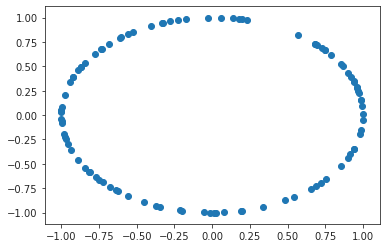

In [5]:
plt.scatter(a[:, 0], a[:, 1])

# Environment Class

In [6]:
class Environment:
    """
      Parameters:
      -----------
      K:  int
          Number of arms generated at each round

      d: int
          Dimension of the problem

      theta: d-dimensional vector
          Key hidden parameter of the problem


      """

    def __init__(self, d, K, theta):
        self.theta = theta
        self.d = d
        self.K = K

    def play(self, chosen_arm):
        """Play the arm with index choice and returns the corresponding reward:

            expected_reward + gaussian_noise
            """

        expected_reward = np.dot(chosen_arm, self.theta)
        reward = np.random.normal(expected_reward)

        return chosen_arm, expected_reward, reward

    def getBestArm(self, arms):
        """Return the index of the best arm and the corresponding expected payoff"""
        payoffs = np.zeros(self.K)
        for i in range(self.K):
            payoffs[i] = np.dot(arms[i, :], self.theta)

        bestArm = np.argmax(payoffs)
        return bestArm, payoffs[bestArm]

# Simulator

In [7]:
class Simulator():
    """
      Simulator of stochastic delayed games.

      Params:
      -------

      policies: list
          List of policies to test.

      K: int
          Number of arms to be generated at each round

      d: int
          Dimension of the problem

      """

    def __init__(self, environment, policies, K, d):
        self.env = environment
        self.policies = policies
        self.d = d
        self.K = K

    def run(self, T, N, q, tsav):
        """Runs an experiment with parameters T and N.

            It returns a dictionary whose keys are policies and whose values
            are the regret obtained by these policies over the experiments and
            averaged over N runs.qRegret and QRegret are the first and third quartiles.

            Parameters
            ----------
            T: int
                Length of the sequential allocations.

            N: int
                Number of Monte Carlo repetitions.

            q: int
                Quantile parameter (e.g. 25 -> quartiles)

            tsav: numpy array (ndim = 1)
                Points to save on each trajectory.
            """
        #Nsub = np.size(tsav)

        regret, cumRegret, N_plays = dict(), dict(), dict()
        Nsub = np.size(tsav)  # Number of points saved for each trajectory
        avgRegret, qRegret, QRegret = dict(), dict(), dict()

        for policy in self.policies:
            name = policy.id()
            cumRegret[name] = np.zeros((N, Nsub))
            regret[name] = np.zeros(T)

        for nExp in range(N):

            if N < 10 or nExp % (N / 5) == 0:
                print("experiments executed:", nExp)
                sys.stdout.flush()

            for policy in self.policies:

                name = policy.id()
                # Reinitialize the policy
                policy.init()
                optimalRewards = np.zeros(T)
                rewards = np.zeros(T)

                # We follow the policy
                # print "ready for experiment %d" % (nExp)
                for t in range(T):

                    # get arms, play one of them (policy), get reward:
                    availableArms = randomActionsGenerator(self.K, self.d)
                    A_t = policy.selectArm(availableArms, self.K)
                    chosen_arm, expected_reward, reward = self.env.play(
                        availableArms[A_t, :])

                    # update the policy:
                    policy.updateState(chosen_arm, reward)

                    # compute instant pseudo regret
                    instantBestArm, instantBestReward = self.env.getBestArm(
                        availableArms)
                    optimalRewards[t] += instantBestReward
                    rewards[t] += expected_reward

                regret[name] += (optimalRewards - rewards)
                cumRegret[name][nExp] += np.cumsum(
                    optimalRewards - rewards)[tsav]

        print("build data out of the experiments")
        for policy in self.policies:
            name = policy.id()
            regret[name] = np.cumsum(regret[name]) / N

            cumReg = cumRegret[name]
            avgRegret[name] = np.mean(cumReg, 0)
            qRegret[name] = np.percentile(cumReg, q, 0)
            QRegret[name] = np.percentile(cumReg, 100 - q, 0)

        print("data built")
        return regret, avgRegret, qRegret, QRegret

# Policies

In [8]:
class Policy(object):

    def __init__(self, K, T):
        """
            Constructor.
            """
        raise NotImplementedError("Method `__init__` is not implemented.")

    def selectArm(self, arms, K):
        """
            This functions selects L arms among the K ones depending on statistics
            over the past observations.
            """
        raise NotImplementedError("Method `selectArms` is not implemented.")

    def updateState(self, chosen_arm, reward):
        """
            This function updates the statistics given the new observations.
            """
        raise NotImplementedError("Method `updateState` is not implemented.")

    def init(self):
        """
            This function updates the statistics given the new observations.
            """
        raise NotImplementedError("Method `updateState` is not implemented.")

    # @staticmethod
    def id(self):
        raise NotImplementedError("Static method `id` is not implemented.")

In [9]:
# Policies :
from numpy.linalg import pinv


class Uniform(Policy):
    def __init__(self, T, d):
        pass

    def selectArm(self, arms, K):
        return np.random.choice(K)

    def updateState(self, chosen_arm, reward):
        pass

    def init(self):
        pass

    # @staticmethod
    def id(self):
        return 'Unif'


## LinUCB : Implementing optimism in $\mathbb{R}^d$

* Implement LinUCB as studied in class. In your opinion, what is (are) the bottleneck(s) of this algorithm ?
<font color="darkblue"> <br> Profiling shows that most time is spend in the environment, sampling random arms at each round. The second most time consuming step is the policy update step which involves inverting matrix V. Third is the regret evaluation (seeking optimal arm). Fourth is the arm selection, which involves some scalar products for each candidate arm.<br>
Sampling arms and seeking regret are part of the environment rather than LinUCB itself<br> <br></font>
* One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. At round $t+1$ the new covariance matrix is very similar to the previous one... Can you think of a way to optimize this step by simply updating the old one ? 
Hint : You can search for a way to compute the inverse of the sum of an invertible matrix A and the outer product, $ uv^\top$, of vectors u and v.
<font color="darkblue"> <br> Done using Sherman-Morrison formula. This makes the state update more than twice faster and, let it fall back behind regret evaluation as the 3rd slowest step in the algorithm <br>
<br></font>
* It is common practice to tweak LinUCB by multiplying the confidence bonus by some hyperparameter $ 0<\alpha <1 $. 
What would be the effect of doing so ? Do you think it is a good idea ? What are the risks ?
<font color="darkblue"> <br>  This would have a similar effect as increasing the parameter delta, i.e. only looking for result is a smaller confidence interval around the estimate (although a change in &delta; would not have a linear effect on the confidence term, they go in the same direction). This makes the algorithm less optimistic and biased towards greedy exploitation.
    
    This increases the probability that the strategy will converge towards a sub-optimal strategy. It may work well is there if the noise on the reward is very small. However, in the generic case, lowering the confidence term will increase the upper bound on the regret of the resulting algorithm.</font>

In [10]:
class LinUCB(Policy):

    def __init__(self, T, d, delta, params):
        self.T = T
        self.params = params
        # dropping the loglog(t) term for now
        self.d = d
        
        if ("lambda" in params):
            self.lambda_reg = params["lambda"]
        else:
            self.lambda_reg = 1

        if "S" in params:
            self.S = params["S"]
        else:
            self.S = 1
        
        # This is computed once for all
        self.beta_factor = -2*np.log(delta) \
                           - d*np.log(self.lambda_reg)
        
    def init(self):

        self.t = 0
        self.weighted_reward_vec = np.zeros((self.d,))
        self.V = np.eye(self.d)*self.lambda_reg

        if self.lambda_reg:
            self.Vinv = np.zeros((self.d,self.d))
        else:
            self.Vinv = np.eye(self.d)/self.lambda_reg
        self.theta_est = np.zeros((self.d,))
        self.beta = 1

    def selectArm(self, arms, K):
        """
            This function implements LinUCB
            Input:
            -------
            arms : list of arms (d-dimensional vectors)

            Output:
            -------
            chosen_arm : index of the pulled arm
            """
        # Take arg max of <arm,theta_estim> + sqrt(beta) norm_(Vt-1) (arm)
        reward_est = np.zeros((K,))
        
        # Vectorize as much as possible
        reward_est = np.dot(arms, self.theta_est)
        tmp = ((arms @ self.Vinv) * arms).sum(axis=1)
        
        reward_est += np.sqrt(self.beta * tmp)

        return reward_est.argmax()
        
    def updateState(self, chosen_arm, reward):
        # accumulate matrix V and vector of chosen arms weighted by rewards
        self.weighted_reward_vec += reward*chosen_arm
        self.V += chosen_arm.reshape(-1, 1) @ \
                  chosen_arm.reshape(1, -1)
        self.t += 1

        #self.Vinv = np.linalg.pinv(self.V)
        # optimized computation of Vinv
        if self.Vinv.any():
            sherman_morrisson(self.Vinv, chosen_arm, chosen_arm, inplace=True)
        else:
            # initialize the first time
            self.Vinv = np.linalg.pinv(self.V)
        
        # compute theta estimate and beta
        self.theta_est = self.Vinv @ self.weighted_reward_vec
        self.beta = np.sqrt(self.lambda_reg)*self.S + \
            np.sqrt(np.log(np.linalg.det(self.V)) + self.beta_factor)
        
    def id(self):
        return "LinUCB"

In [11]:
def sherman_morrisson(Ainv,u,v, inplace=False):
    '''
    Return the inverse of (A + u.vT) accordin to Sherman Morrison formula
    '''
    # Create 2D versions of the vectors u and vt
    u = u.reshape(-1,1)
    vt = v.reshape(1,-1)
    
    # Sherman-Morrison formula
    update = (Ainv @ u @ vt @ Ainv) / (1 + vt @ Ainv @ u)
    
    # update in place or out of place
    if inplace:
        Ainv -= update
        return None
    else:
        return Ainv - update

<font color="darkblue">

## Linear Thompson sampling


In the Ridge regression with a design matrix $X$ and observed values $y$, we seek: $$\hat{\theta}_{\text{ridge},\lambda} = \underset{\theta}{\operatorname{argmin}} \Vert X \theta - y\Vert^2_2 + \lambda \Vert \theta \Vert^2_2$$

We assume that $y = X \theta^* + \epsilon$ where $\theta^*$ is the true parameter of the model and $\epsilon \sim \mathcal{N}(\mathbf{0},\sigma^2 I)$ is a vector of independant, identically distributed random variables following a centered gaussian distribution of variance $\sigma^2$.

Then $\hat{\theta}_{\text{ridge},\lambda}$ is a biased estimator of $\theta^*$, given by the closed form formula:
$$\hat{\theta}_{\text{ridge},\lambda} = (X^\top X + \lambda I)^{-1} X^\top y$$
Its covariance is:
$$\operatorname{\mathbb{C}ov}(\hat{\theta}_{\text{ridge},\lambda}) = 
\sigma^2 (X^\top X + \lambda I)^{-1} X^\top X [(X^\top X + \lambda I)^{-1}]^\top$$


The Linear Thompson sampling scheme is achieved by sampling a value for &theta; according to the current estimate, i.e. a normal distribution centered on $\hat{\theta}_\lambda$ with covariance $\operatorname{\mathbb{C}ov}(\hat{\theta}_{\text{ridge},\lambda})$. For this purpose, we need to store the following matrices and vectors:
$$X^\top y  =  \sum_{i=1}^n X_i^\top y_i $$
$$X^\top X  =  \sum_{i=1}^n X_i^\top X_i $$
$$(X^\top X +\lambda I)^{-1}$$
They can all be updated incrementally, the last one woth the Sherman-Morrison formula.

The parameters will be the regularization parameter $\lambda$ and some estimate of the variance of the noise $\sigma^2$.

Ridge regression is equivalent to adding a gaussian prior to the distribution of $\theta$, with $\theta \sim \mathcal{N}(\mathbf{0},\sigma_0^2 I)$ and $\lambda = 1/\sigma_0^2$. Still, the $\sigma_0^2$ from the Gaussian prior is not related to the noise $\sigma^2$ on the observations $y_i$.
    
</font>

In [12]:
class LinTS(Policy):

    def __init__(self, T, d, **kwargs):
        self.T = T
        self.params = kwargs
        self.d = d
        
        if ("lambda_reg" in kwargs):
            self.lambda_reg = kwargs["lambda_reg"]
        elif ("sigma0" in kwargs):
            self.lambda_reg = 1 / kwargs["sigma0"]**2
        else:
            self.lambda_reg = 1

        if "sigma2" in kwargs:
            self.sigma2 = kwargs["sigma2"]
        else:
            self.sigma2 = 1
        
    def init(self):

        self.t = 0
        self.Xt_y = np.zeros((self.d,))
        self.Xt_X = np.zeros((self.d,self.d))
        self.Vinv = np.eye(self.d)/self.lambda_reg
        
        # initialization will give a random direction
        self.theta_est = np.zeros((self.d,))
        self.theta_cov = np.eye(self.d)
        
    def selectArm(self, arms, K):
        """
            This function implements LinTS
            Input:
            -------
            arms : list of arms (d-dimensional vectors)

            Output:
            -------
            chosen_arm : index of the pulled arm
            """
        # Sample theta
        theta_sample = np.random.multivariate_normal(
            self.theta_est, self.theta_cov)
        
        # Pick best reward
        reward_est = arms @ theta_sample
        return reward_est.argmax()
        
    def updateState(self, chosen_arm, reward):
        # accumulate XT.X, XT.y and (XT.X + lambda I)^(-1)
        self.Xt_y += reward*chosen_arm
        self.Xt_X += chosen_arm.reshape(-1, 1) @ \
                      chosen_arm.reshape(1, -1)
        self.t += 1

        sherman_morrisson(self.Vinv, chosen_arm, chosen_arm, inplace=True)
        
        # compute theta estimate and covariance
        self.theta_est = self.Vinv @ self.Xt_y
        self.theta_cov = self.sigma2 * self.Vinv @ self.Xt_X @ self.Vinv.T
        
    def id(self):
        return "LinTS"

# main

In [13]:
%load_ext line_profiler

In [18]:
import time
import numpy as np
import pickle

d = 15  # dimension
K = 30  # number of arms

# parametor vector \theta, normalized :
theta = np.random.randint(2, size=d)
theta = theta / np.linalg.norm(theta)


T = 1000  # Finite Horizon
N = 10  # Monte Carlo simulations

delta = 0.1

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

# choice of quantile display
q = 10


# Create an object of K arms with delayed feedback with mean delay tau
env = Environment(d, K, theta)
# Policies to evaluate
policies = [LinUCB(T, d, delta, params={"lambda":1}),
            LinTS(T,d, lambda_reg=.1, sigma2=1),
            Uniform(T, d)]

simulator = Simulator(env, policies, K, d)

#%lprun -f Simulator.run -f LinUCB.selectArm\
regret, avgRegret, qRegret, QRegret = simulator.run(T, N, q, tsav)

data = [[
    policy, regret[policy], avgRegret[policy], qRegret[policy],
    QRegret[policy]
] for policy in avgRegret]



# data
#   with open('linucb_test' + str(d) + '_dim-' + str(K) + '_K' + '.pkl',
#             'wb') as foutput:
#     pickle.dump(data, foutput, protocol=2)

experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
data built


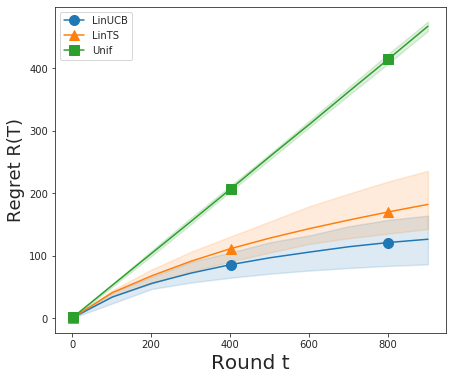

In [19]:
freq = 10
plot_regret(
    data,
    tsav,
    'linucb_test' + str(d) + '_dim-' + str(K) + '_K',
    log=False,
    freq=freq,
    qtl=True)